<a href="https://colab.research.google.com/github/Anna671/VAE_CelebFaces/blob/main/VAE_CelebFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В данном проекте используется вариационный автоэнкодер для генерации лиц знаменитостей / This project uses a variational autoencoder to generate celebrity faces.


Импорт библиотек / Importing Libraries

In [ ]:
import numpy as np # linear algebra/ линейная алгебра
import pandas as pd # data processing/ обработка данных CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import cv2 as cv
import matplotlib.pyplot as plt

Скачивание данных c kaggle.com / Downloading data from kaggle.com

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annaguskova","key":"40aae2602cabb9aaa3df4569493bb55a"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=b2146dc81a94eda9b6d2b473a7885538701c69124334e01c913d1dcede6b6072
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:20<00:00, 96.2MB/s]
100% 1.33G/1.33G [00:20<00:00, 68.2MB/s]


In [ ]:
! unzip /content/celeba-dataset.zip -d kaggle 

In [ ]:
names = glob('/content/kaggle/img_align_celeba/img_align_celeba/*.jpg')
names

Подготовка изображений / Preparing images

In [ ]:
def img_preprocess():
    i=0
    img_list = []
    while i<1000:
        img_path = names[i]
        img = cv.imread(img_path)            #cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB / cv 3-dim，last_channel = 3，RGB
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # - OpenCV считывает изображения в BGR, а не RGB, поэтому нужно преобразование
        img = cv.resize(img, (180, 180))     #преобразование формы в (224, 224) / shape (224, 224)
        sc_img = img.astype('float') / 255   #нормализация / normalization
        img_list.append(sc_img)
        i=i+1
    return np.asarray(img_list)

In [ ]:
img_arr = img_preprocess()

([], <a list of 0 Text major ticklabel objects>)

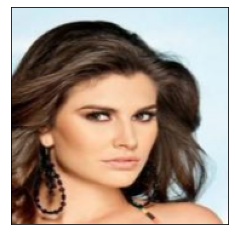

In [ ]:
plt.imshow(img_arr[695])
plt.xticks([])
plt.yticks([])

In [ ]:
img_arr.shape

(1000, 180, 180, 3)

Построение модели / Build Model

Вариационный автоэнкодер / Variation autoencoder

In [ ]:
from sklearn.model_selection import train_test_split
(x_train, x_test) = train_test_split(img_arr, test_size = 0.10, random_state = 0)

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# network parameters
input_shape = (x_train.shape[1], x_train.shape[2], 3)
filters = 20
latent_dim = 52


inputs = Input(shape=input_shape, name='encoder_input')

x = inputs

for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)
    filters *= 2

shape = K.int_shape(x)

x = Flatten()(x)

# x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    filters //= 2
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])

# Создание вариационного автоэнкодера / Variation autoencoder
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= x_train.shape[1]*x_train.shape[2]

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(reconstruction_loss, 'rec_loss')
vae.add_metric(kl_loss, 'kl_loss')

vae.compile(optimizer=keras.optimizers.Adam(lr=0.01))

vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 20)   560         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 45, 45, 40)   7240        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 81000)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

Обучение модели / Model training

In [ ]:
vae.fit(
    x_train,
    x_train,
    epochs=150,
    batch_size=128,
    validation_data=(x_test, x_test),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=30, restore_best_weights=True)]
)

In [ ]:
test_rec = vae.predict(x_test)

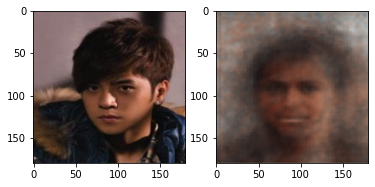

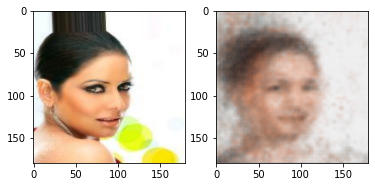

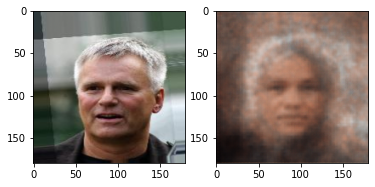

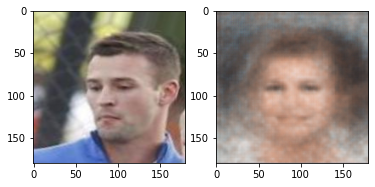

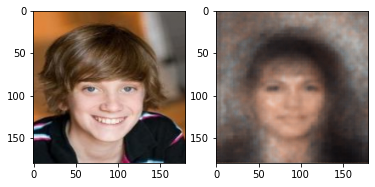

In [ ]:

for i in range(5):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(x_test[i+1], vmin=0, vmax=1)
    ax[1].imshow(test_rec[i+1], vmin=0, vmax=1)